In [1]:
import numpy as np
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cred_data = pd.read_csv("datos/creditcard.csv")

In [3]:
cred_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
cred_data.shape

(284807, 31)

In [5]:
X_train = cred_data[cred_data['Class'] == 0].drop(columns=['Class']).values
X_train, X_val = train_test_split(X_train, 
                                   test_size=0.2, 
                                   random_state=42)

y_val = np.zeros(X_val.shape[0])
X_test = cred_data[cred_data['Class'] == 1].drop(columns=['Class']).values
y_test = np.ones(X_test.shape[0])
X_val, X_test, y_val, y_test = train_test_split(np.concatenate((X_val, X_test), axis=0), 
                                                np.concatenate((y_val, y_test), axis=0), 
                                                test_size=0.5,
                                                stratify=np.concatenate((y_val, y_test), axis=0), 
                                                random_state=42)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((227452, 30), (28677, 30), (28678, 30))

In [7]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train).astype(np.float16)
X_val = scaler.transform(X_val).astype(np.float16)
X_test = scaler.transform(X_test).astype(np.float16)

In [8]:
features = X_train.shape[1]

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, X_train)).batch(256).shuffle(1024).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, X_val)).batch(256).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, X_test)).batch(256).prefetch(tf.data.AUTOTUNE)

2026-01-27 19:56:06.765531: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-27 19:56:06.765548: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-27 19:56:06.765552: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-27 19:56:06.765584: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-27 19:56:06.765594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
def create_autoencoder(features, units_1, units_2, activation):
    model = Sequential()
    model.add(Input(shape=(features,)))
    model.add(Dense(units_1, activation=activation))
    model.add(Dropout(0.1))
    model.add(Dense(units_2, activation=activation))
    model.add(Dense(2, activation='linear'))
    model.add(Dense(units_2, activation=activation))
    model.add(Dense(units_1, activation=activation))
    model.add(Dropout(0.1))
    model.add(Dense(features, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=5e-3), 
        loss='mse',
        metrics=['mae']
    )

    return model

In [11]:
def build_model(hp, features):
    units_1 = hp.Int("units_1", 32, 64, step=16)
    units_2 = hp.Int("units_2", 4, 8, step=2)
    activation = hp.Choice("activation", ["tanh", "leaky_relu"])

    model = create_autoencoder(features, units_1, units_2, activation)

    return model
    

In [12]:
tuner = kt.Hyperband(
    hypermodel=lambda hp: build_model(hp, features),
    objective="val_mae",
    max_epochs=15,
    factor=10,
    directory="hyperband_dir",
    project_name="hyperband_project",
    overwrite=True,
    seed=42,
)

In [13]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
        EarlyStopping(monitor='val_mae', patience=5),
    ],
    verbose=1,
)

Trial 19 Complete [00h 01m 01s]
val_mae: 0.5762764811515808

Best val_mae So Far: 0.5744369029998779
Total elapsed time: 00h 05m 58s


In [14]:
best_hps = tuner.get_best_hyperparameters(1)[0]
autoencoder = create_autoencoder(
    features,
    best_hps.get("units_1"),
    best_hps.get("units_2"),
    best_hps.get("activation"),
)

In [30]:
print(best_hps.values)

{'units_1': 64, 'units_2': 6, 'activation': 'leaky_relu', 'tuner/epochs': 15, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0012'}


In [15]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1984      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                                 
 dense_8 (Dense)             (None, 2)                 14        
                                                                 
 dense_9 (Dense)             (None, 6)                 18        
                                                                 
 dense_10 (Dense)            (None, 64)                448       
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [16]:
autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[EarlyStopping(monitor='val_mae', patience=5),
               ReduceLROnPlateau(monitor='val_mae', factor=0.75, patience=3, min_lr=1e-6),
    ],
    verbose=1,
)

Epoch 1/100
889/889 [==============================] - 4s 4ms/step - loss: 1.1065 - mae: 0.6309 - val_loss: 1.1720 - val_mae: 0.6197 - lr: 0.0050
Epoch 2/100
889/889 [==============================] - 4s 4ms/step - loss: 0.9580 - mae: 0.6025 - val_loss: 1.1231 - val_mae: 0.6098 - lr: 0.0050
Epoch 3/100
889/889 [==============================] - 4s 4ms/step - loss: 0.9141 - mae: 0.5961 - val_loss: 1.0581 - val_mae: 0.6075 - lr: 0.0050
Epoch 4/100
889/889 [==============================] - 4s 4ms/step - loss: 0.8728 - mae: 0.5916 - val_loss: 1.0345 - val_mae: 0.5978 - lr: 0.0050
Epoch 5/100
889/889 [==============================] - 4s 4ms/step - loss: 0.8584 - mae: 0.5882 - val_loss: 1.0349 - val_mae: 0.6023 - lr: 0.0050
Epoch 6/100
889/889 [==============================] - 4s 4ms/step - loss: 0.8514 - mae: 0.5874 - val_loss: 0.9914 - val_mae: 0.5897 - lr: 0.0050
Epoch 7/100
889/889 [==============================] - 4s 4ms/step - loss: 0.8402 - mae: 0.5857 - val_loss: 1.0051 - val_mae

In [17]:
X_train_pred = autoencoder.predict(train_ds)
train_mae = np.mean(np.abs(X_train - X_train_pred), axis=1)

889/889 [==============================] - 1s 1ms/step


In [28]:
threshold = np.quantile(train_mae, 0.9)
threshold

1.280277144908905

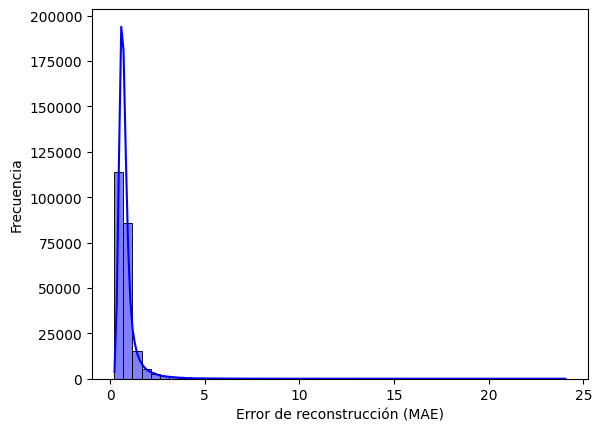

In [19]:
ax = sns.histplot(train_mae, bins=50, color='blue', alpha=0.5, kde=True)
ax.set_xlabel("Error de reconstrucción (MAE)")
ax.set_ylabel("Frecuencia")
plt.show()

In [23]:
X_test_pred = autoencoder.predict(test_ds)
test_mae = np.mean(np.abs(X_test - X_test_pred), axis=1)

113/113 [==============================] - 0s 2ms/step


In [29]:
y_pred = (test_mae > threshold).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     28432
         1.0       0.32      0.80      0.45       246

    accuracy                           0.98     28678
   macro avg       0.66      0.89      0.72     28678
weighted avg       0.99      0.98      0.99     28678

